In [1]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json


All models are subject to betterment with more stringent hyper-parameter tuning. This can be achieved by random selection, brute force methods, etc. Various other classifiers can also be used, but the most standard classifiers have been considered in this notebook.

The best recall achieved was **91%** with and average of **89.5%**. An accuracy of **94%** has also been achieved. 

Recommend standard practices for data transformation, outlier detection, and null value substitution have been incorporated in this notebook

1. Import Libraries 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
#! kaggle datasets download fedesoriano/heart-failure-prediction


In [4]:
#! unzip heart-failure-prediction.zip

In [5]:
df  = pd.read_csv('../input/heart-failure-prediction/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


2. Explore Dataset

In [6]:
def describe(df):                        # Function to explore major elements in a Dataset
                                         # Will help to find null values present and deal with them
  columns=df.columns.to_list()           # Function will help to directly find numerical and categorical columns
  ncol=df.describe().columns.to_list()
  ccol=[]
  for i in columns:
    if(ncol.count(i)==0):
      ccol.append(i)
    else:
      continue
  print('Name of all columns in the dataframe:')
  print(columns)
  print('')
  print('Number of columns in the dataframe:')
  print(len(columns))
  print('')
  print('Name of all numerical columns in the dataframe:')
  print(ncol)
  print('')
  print('Number of numerical columns in the dataframe:')
  print(len(ncol))
  print('')
  print('Name of all categorical columns in the dataframe:')
  print(ccol)
  print('')
  print('Number of categorical columns in the dataframe:')
  print(len(ccol))
  print('')
  print('------------------------------------------------------------------------------------------------')
  print('')
  print('Number of Null Values in Each Column:')
  print('')
  print(df.isnull().sum())
  print('')
  print('')
  print('Number of Unique Values in Each Column:')
  print('')
  print(df.nunique())
  print('')
  print('')
  print('Basic Statistics and Measures for Numerical Columns:')
  print('')
  print(df.describe().T)
  print('')
  print('')
  print('Other Relevant Metadata Regarding the Dataframe:')
  print('')
  print(df.info())
  print('')
  print('')



  


In [7]:
describe(df)


Name of all columns in the dataframe:
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Number of columns in the dataframe:
12

Name of all numerical columns in the dataframe:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Number of numerical columns in the dataframe:
7

Name of all categorical columns in the dataframe:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Number of categorical columns in the dataframe:
5

------------------------------------------------------------------------------------------------

Number of Null Values in Each Column:

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Number of Unique Value

2.1 Vizualize Data in Terms of Target Variable

<AxesSubplot:xlabel='FastingBS', ylabel='Count'>

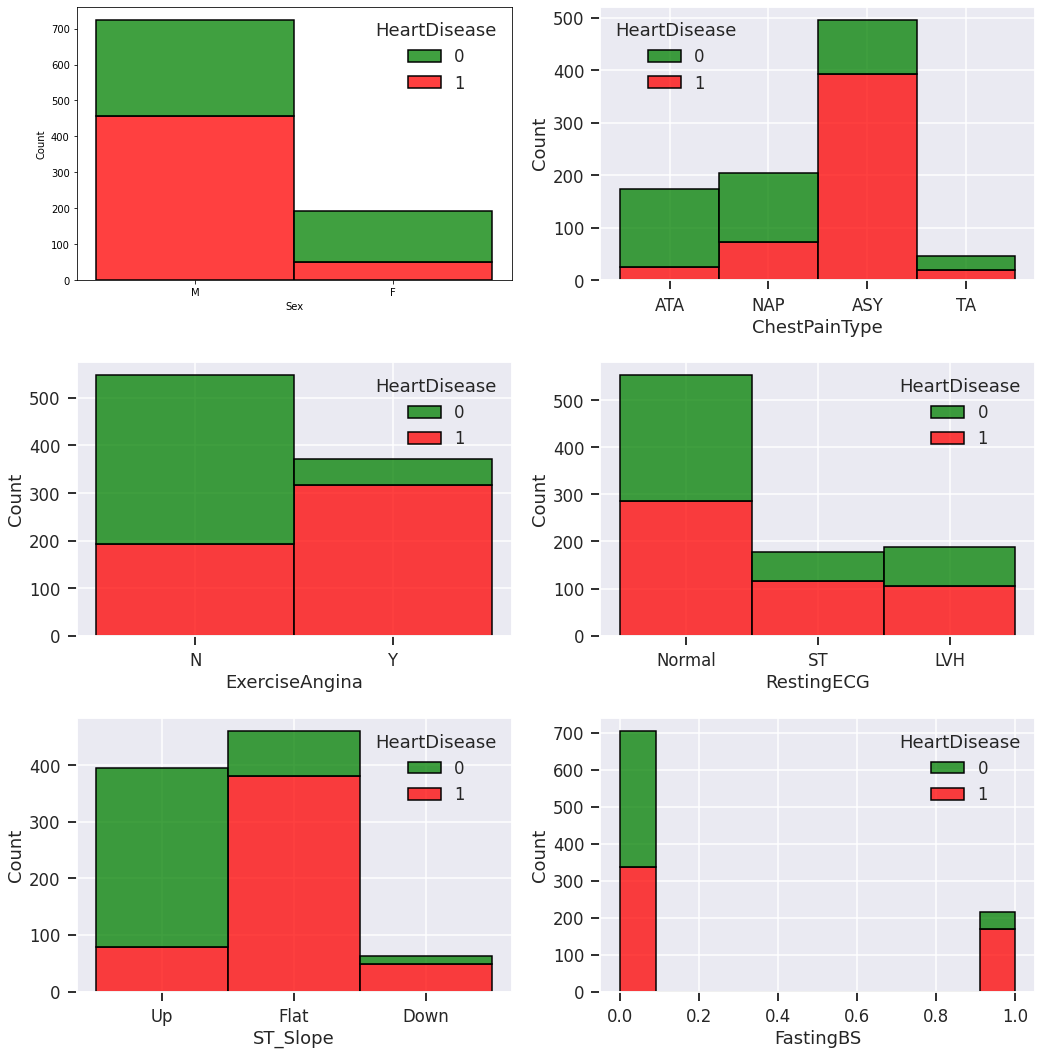

In [8]:
oe=['g','r']
fig = plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="Sex", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='Sex ', ylabel='Count')

plt.subplot(3,2,2)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="ChestPainType", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='ChestPainType', ylabel='Count')

plt.subplot(3,2,3)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="ExerciseAngina", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='ExerciseAngina', ylabel='Count')

plt.subplot(3,2,4)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="RestingECG", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='RestingECG', ylabel='Count')

plt.subplot(3,2,5)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="ST_Slope", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='ST_Slope', ylabel='Count')

plt.subplot(3,2,6)
plt.style.use('seaborn')
plt.tight_layout()
sns.set_context('talk')
sns.histplot(data=df, x="FastingBS", hue="HeartDisease",multiple="stack",palette=oe)
#ax.set(xlabel='FastingBS', ylabel='Count')

3. Outlier Detection

In [9]:
def outliers(df_column):
  q75, q25 = np.percentile(df_column, [75 ,25]) 
  iqr = q75 - q25
  print('q75: ',q75)
  print('q25: ',q25)
  print('Inter Quartile Range: ',iqr)
  print('Outliers lie before', q25-1.8*iqr, 'and beyond', q75+1.8*iqr) 

  # Usually 1.5 times IQR is considered, but we have used 1.8 for broader range

  print('Number of Rows with Left Extreme Outliers:', len(df[df_column <q25-1.8*iqr]))
  print('Number of Rows with Right Extreme Outliers:', len(df[df_column>q75+1.8*iqr]))
  plt.tight_layout()
  plt.style.use('seaborn')
  sns.set_context('notebook')
  sns.histplot(data=df, x=df_column, hue="HeartDisease",multiple="stack",palette=oe)

  

q75:  140.0
q25:  120.0
Inter Quartile Range:  20.0
Outliers lie before 84.0 and beyond 176.0
Number of Rows with Left Extreme Outliers: 2
Number of Rows with Right Extreme Outliers: 23


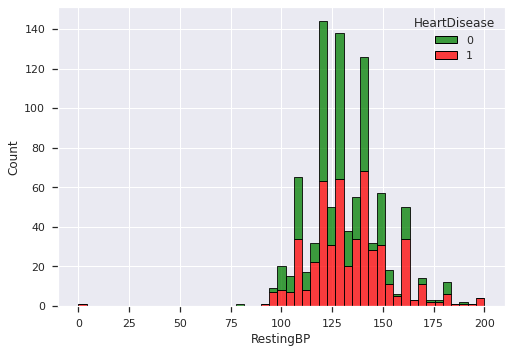

In [10]:
outliers(df['RestingBP']) 

In [11]:
# Since outliers are slightly skewed towards the right extreme side, we will keep them for now and just drop the left extreme values
df=df[df.RestingBP>=84]
len(df)



916

In [12]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


q75:  267.0
q25:  174.75
Inter Quartile Range:  92.25
Outliers lie before 8.699999999999989 and beyond 433.05
Number of Rows with Left Extreme Outliers: 170
Number of Rows with Right Extreme Outliers: 8


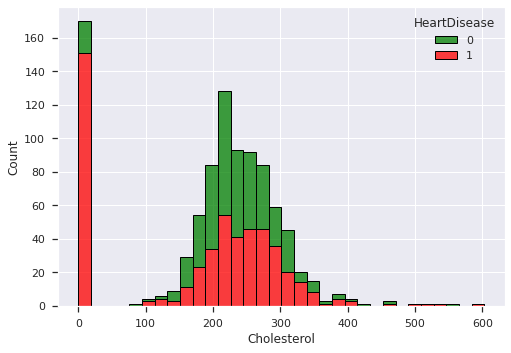

In [13]:
outliers(df['Cholesterol']) 
# Multiple Values of 0 value are present
#Since Cholesterol value can't be zero, these values are missing and have to be dealt with prior to model creation


In [14]:
df=df[df.Cholesterol<=500]
df.head()
len(df)

912

q75:  156.0
q25:  120.0
Inter Quartile Range:  36.0
Outliers lie before 55.2 and beyond 220.8
Number of Rows with Left Extreme Outliers: 0
Number of Rows with Right Extreme Outliers: 0


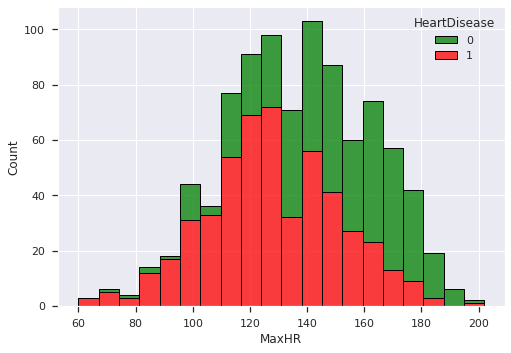

In [15]:
outliers(df['MaxHR'])

q75:  1.5
q25:  0.0
Inter Quartile Range:  1.5
Outliers lie before -2.7 and beyond 4.2
Number of Rows with Left Extreme Outliers: 0
Number of Rows with Right Extreme Outliers: 4


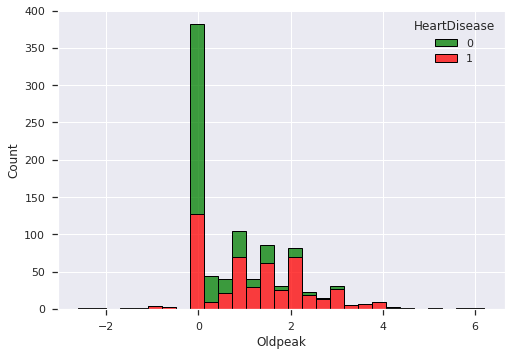

In [16]:
outliers(df['Oldpeak'])

In [17]:
df[df.Cholesterol==0].mean() #Effort to understand how data looks like where values are missing, i.e. 0 Cholesterol 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Age              56.264706
RestingBP       130.735294
Cholesterol       0.000000
FastingBS         0.523529
MaxHR           121.682353
Oldpeak           0.814706
HeartDisease      0.888235
dtype: float64

In [18]:
df[df.Cholesterol>0].mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Age              52.889488
RestingBP       133.055256
Cholesterol     242.970350
FastingBS         0.167116
MaxHR           140.247978
Oldpeak           0.902965
HeartDisease      0.475741
dtype: float64

In [19]:
print('Mean: ',df['Cholesterol'].mean())
print('Median: ',df['Cholesterol'].median())

Mean:  197.6798245614035
Median:  222.5


In [20]:
df[df['Cholesterol']>0].Cholesterol.mean()

242.97035040431265

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,912.0,53.518640,9.425989,28.0,47.00,54.00,60.00,77.0
RestingBP,912.0,132.622807,17.943938,92.0,120.00,130.00,140.00,200.0
Cholesterol,912.0,197.679825,106.763321,0.0,173.75,222.50,266.25,491.0
FastingBS,912.0,0.233553,0.423323,0.0,0.00,0.00,0.00,1.0
MaxHR,912.0,136.787281,25.519987,60.0,120.00,138.00,156.00,202.0
Oldpeak,912.0,0.886513,1.068172,-2.6,0.00,0.55,1.50,6.2
HeartDisease,912.0,0.552632,0.497495,0.0,0.00,1.00,1.00,1.0


4. Convert Categorical Variables into Numerical by One Hot Encoding

In [22]:
def OHE(dfcolumn):
  global df
  dfcolumn.nunique()
  len(df.columns)
  finallencol = (dfcolumn.nunique() - 1) + (len(df.columns)-1)
  dummies = pd.get_dummies(dfcolumn, drop_first=True, prefix=dfcolumn.name)
  df=pd.concat([df,dummies],axis='columns')
  df.drop(columns=dfcolumn.name,axis=1,inplace=True) # We have to drop columns to aviod multi-collinearity
  if(finallencol==len(df.columns)):
    print('One Hot Encoding was successful!') 
    print('')
  else:
    print('Error in OHE XXXX')
  return df


In [23]:
OHE(df['ChestPainType'])
OHE(df['Sex'])
OHE(df['RestingECG'])
OHE(df['ExerciseAngina'])
OHE(df['ST_Slope'])


One Hot Encoding was successful!

One Hot Encoding was successful!

One Hot Encoding was successful!

One Hot Encoding was successful!

One Hot Encoding was successful!



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,0,1,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,0,0,1,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,0,1,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,0,0,1,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,0,0,0,1,1,0,0,1,0
915,57,130,131,0,115,1.2,1,0,0,0,1,1,0,1,1,0
916,57,130,236,0,174,0.0,1,1,0,0,0,0,0,0,1,0


5. Data Transformation Before Model Building

In [24]:
# Imupute Values for 0 Cholesterol, Method Used: KNN-Imputation 

df['Cholesterol'].replace(to_replace = 0, value =np.nan, inplace=True)
KNN_imputed = KNNImputer(n_neighbors=5)
I=KNN_imputed.fit_transform(df)
Cholesterol=[]
for i in range(0,len(df)):
  Cholesterol.append(I[i][2])
df['Cholesterol']=Cholesterol 

In [25]:
# Find VIF (Variance Inflation Factor) To Check for collinearity among independent variables
vif = df.copy()
vif.drop(columns='HeartDisease',axis=1,inplace=True)
vif_data = pd.DataFrame()
vif_data["feature"] = vif.columns
vif_data["VIF"] = [variance_inflation_factor(vif.values, i)
                          for i in range(len(vif.columns))]


In [26]:
vif_data # Standard practice is to deal with variables with VIF >= 10

,feature,VIF
0,Age,33.387612
1,RestingBP,53.889014
2,Cholesterol,23.587329
3,FastingBS,1.431929
4,MaxHR,27.855792
5,Oldpeak,2.569567
6,ChestPainType_ATA,1.841542
7,ChestPainType_NAP,1.626664
8,ChestPainType_TA,1.184258
9,Sex_M,4.895356


In [27]:
# Scale Data For Higher Efficiency

from sklearn.preprocessing import StandardScaler # Converts Columnar Data into Standard Normal Distribution
scaler=StandardScaler()
scaler.fit(vif)
scaled_data=scaler.transform(vif)
scaled_data



array([[-1.43497494,  0.41135011,  0.90884654, ..., -0.82435309,
        -0.99780942,  1.14405453],
       [-0.47964407,  1.52654424, -1.2497362 , ..., -0.82435309,
         1.00219539, -0.87408421],
       [-1.75341857, -0.14624695,  0.79002547, ..., -0.82435309,
        -0.99780942,  1.14405453],
       ...,
       [ 0.36953893, -0.14624695, -2.22010825, ...,  1.21307243,
         1.00219539, -0.87408421],
       [ 0.36953893, -0.14624695, -0.14073956, ..., -0.82435309,
         1.00219539, -0.87408421],
       [-1.64727069,  0.2998307 , -1.34875375, ..., -0.82435309,
        -0.99780942,  1.14405453]])

In [28]:
from sklearn.decomposition import PCA # Reduce Dimensions by Principal Component Analysis To Compensate for Variables with High VIF
pca=PCA(n_components=11)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
x_pca

array([[ 2.96196536, -0.32607017,  1.65159492, ..., -0.48242366,
        -0.96897897, -0.29772444],
       [ 0.284037  , -1.05263117, -1.10757972, ..., -1.99653336,
        -0.69976878,  0.44105539],
       [ 1.5284447 ,  2.19764344,  1.21517963, ...,  0.81540077,
        -1.25161928,  0.37361669],
       ...,
       [-1.51604508, -1.64883654, -0.71441383, ..., -0.5043577 ,
         0.13243627,  0.33962526],
       [ 1.01169527,  0.3660804 ,  1.5499496 , ..., -1.26051025,
        -0.1881711 , -1.24151054],
       [ 2.67043799, -0.61322532, -2.16689401, ..., -0.922637  ,
        -0.80415661,  0.55521724]])

**6. Final Model and Algorithms Used**

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_pca, df['HeartDisease'], test_size=0.25, random_state=0)

6.1 Support Vector Machine (Radial Basis Function Kernel)

In [30]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        92
           1       0.93      0.87      0.90       136

    accuracy                           0.88       228
   macro avg       0.88      0.88      0.88       228
weighted avg       0.89      0.88      0.88       228


------------------------
Confusion Matrix
------------------------

[[ 83   9]
 [ 18 118]]


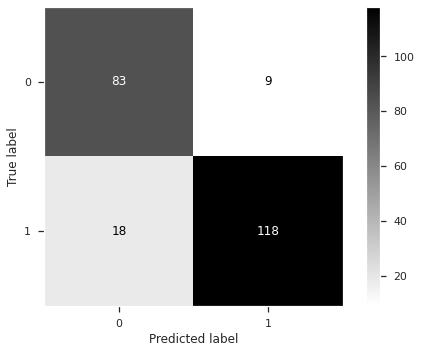

In [31]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(classifier, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()

6.2 Logistic Regression Function

In [32]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
print('')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy of logistic regression classifier on test set: 0.89

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        92
           1       0.93      0.87      0.90       136

    accuracy                           0.88       228
   macro avg       0.88      0.88      0.88       228
weighted avg       0.89      0.88      0.88       228

[[ 83   9]
 [ 18 118]]


6.3 Random Forest Classifier

In [33]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 103, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s


[CV] n_estimators=124, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=124, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.5s
[CV] n_estimators=212, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=212, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=212, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=212, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=256, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=256, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.0s
[CV] n_estimators=168, min_sampl

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.8s



[CV] n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.5s
[CV] n_estimators=190, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=190, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   0.7s
[CV] n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.4s
[CV] n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=124, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.4s
[CV] n_estimators=212, 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [103, 124, 146, 168,
                                                         190, 212, 234, 256,
                                                         278, 300]},
                   random_state=42, verbose=2)

In [35]:
rf_random.best_params_

{'n_estimators': 124,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        92
           1       0.89      0.88      0.88       136

    accuracy                           0.86       228
   macro avg       0.86      0.86      0.86       228
weighted avg       0.87      0.86      0.86       228


------------------------
Confusion Matrix
------------------------

[[ 78  14]
 [ 17 119]]


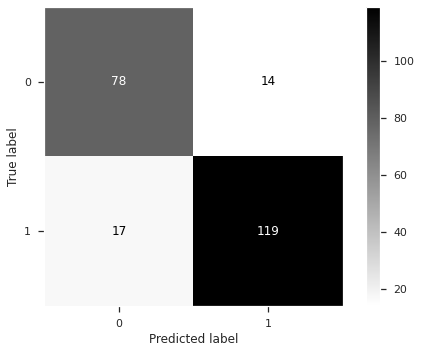

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_pca, df['HeartDisease'], test_size=0.25, random_state=0)
clf=RandomForestClassifier(n_estimators=124,min_samples_split= 2,
                           min_samples_leaf= 1,max_features='sqrt',max_depth=None, bootstrap=False)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(clf, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()

6.4 Support Vector Machine (Radial Basis Function Kernel) with Grid Search CV

In [37]:

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(x_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.533, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.540, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.540, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.540, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.537, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.869, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.839, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.861, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.796, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.838, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.533, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.540, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.540, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001)
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        92
           1       0.91      0.87      0.89       136

    accuracy                           0.87       228
   macro avg       0.87      0.87      0.87       228
weighted avg       0.88      0.87      0.87       228


------------------------
Confusion Matrix
------------------------

[[ 81  11]
 [ 18 118]]


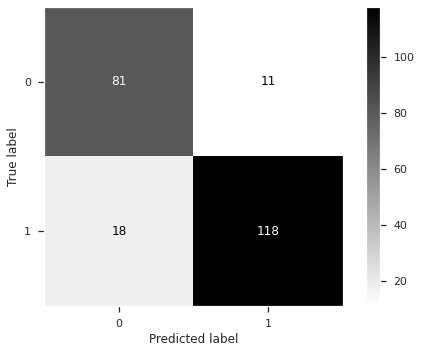

In [38]:
print(grid.best_params_)
print(grid.best_estimator_)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(grid, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()



6.5 Neural Network Using Tensor flow 

In [39]:
import tensorflow as tf
tf.random.set_seed(0)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(x_train, y_train, epochs=100)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/100
22/22 [==============================] - 1s 3ms/step - loss: 0.4474 - accuracy: 0.8041 - precision: 0.8047 - recall: 0.8397
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8699 - precision: 0.8514 - recall: 0.9185
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.8801 - precision: 0.8743 - recall: 0.9076
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8787 - precision: 0.8645 - recall: 0.9185
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.3017 - accuracy: 0.8874 - precision: 0.8819 - recall: 0.9130
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.2981 - accuracy: 0.8787 - precision: 0.8780 - recall: 0.8995
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.2764 - accuracy: 0.8845 - precision: 0.8813 - recall: 0.9076
Epoch 8/100
22/22 [=============================

In [40]:
predictions = model.predict(x_test)
y_pred = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.77      0.91      0.84        92
           1       0.93      0.82      0.87       136

    accuracy                           0.86       228
   macro avg       0.85      0.86      0.85       228
weighted avg       0.87      0.86      0.86       228


------------------------
Confusion Matrix
------------------------

[[ 84   8]
 [ 25 111]]


6.6 KNN Classifier

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        92
           1       0.92      0.88      0.90       136

    accuracy                           0.89       228
   macro avg       0.88      0.89      0.88       228
weighted avg       0.89      0.89      0.89       228


------------------------
Confusion Matrix
------------------------

[[ 82  10]
 [ 16 120]]


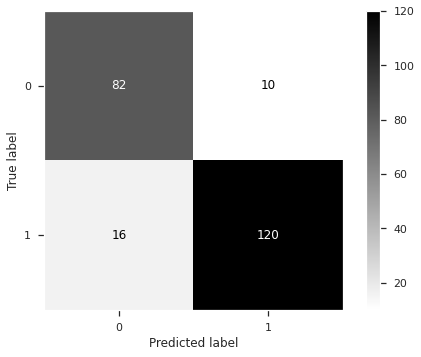

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_pca, df['HeartDisease'], test_size=0.25, random_state=0)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)
y_pred=knn.predict(x_test)
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(knn, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()

6.7 Gaussian Navie Bayes Algorithm

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        92
           1       0.93      0.85      0.89       136

    accuracy                           0.87       228
   macro avg       0.87      0.88      0.87       228
weighted avg       0.88      0.87      0.87       228


------------------------
Confusion Matrix
------------------------

[[ 84   8]
 [ 21 115]]


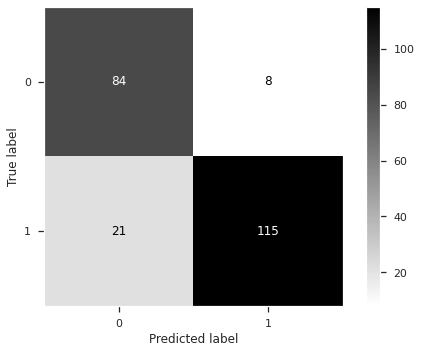

In [42]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred=gnb.predict(x_test)
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(gnb, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()

6.8 Gradient Boosting Algorithm

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        92
           1       0.94      0.88      0.91       136

    accuracy                           0.89       228
   macro avg       0.89      0.90      0.89       228
weighted avg       0.90      0.89      0.90       228


------------------------
Confusion Matrix
------------------------

[[ 84   8]
 [ 16 120]]


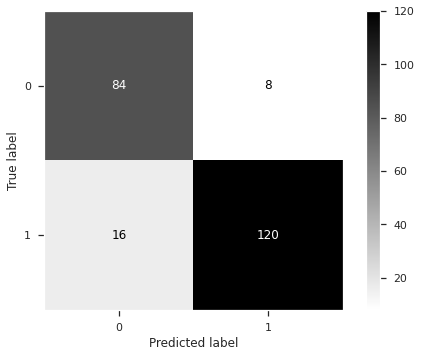

In [43]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_pca, df['HeartDisease'], test_size=0.25, random_state=0)
clff = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=1, random_state=23)
clff.fit(x_train, y_train)
y_pred=clff.predict(x_test)
print(classification_report(y_test, y_pred))
print('')
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(clff, x_test, y_test,cmap="binary") 
plt.grid(False)
plt.show()
